## This notebook will run and analyse the Model for the Subway Data


## Random forest model training

In [3]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor



In [4]:
##Writing installed packages to requirements.txt file
!pip freeze > subway_requirements.txt

In [5]:
#import the csv file needed to train the model
df=pd.read_csv('cleaned_busyness_data.csv')
df.head(10)

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month,temperature,weather,rain_fall,snow_fall,station_category
0,1,1546315200,102,104,206,0,4,Tuesday,January,5.89,Rain,3.77,2.21,1
1,1,1546329600,96,51,147,0,8,Tuesday,January,11.18,Mist,0.00,0.12,1
2,1,1546344000,260,476,736,0,12,Tuesday,January,13.55,Rain,0.25,0.06,1
3,1,1546358400,540,496,1036,0,16,Tuesday,January,11.68,Rain,0.50,0.25,1
4,1,1546372800,602,250,852,0,20,Tuesday,January,3.70,Clouds,0.00,0.05,1
5,1,1546387200,159,147,306,0,0,Wednesday,January,2.05,Clouds,0.00,0.00,1
6,1,1546401600,48,38,86,0,4,Wednesday,January,-0.06,Clouds,0.00,0.00,1
7,1,1546416000,516,434,950,0,8,Wednesday,January,-2.08,Clear,0.00,0.00,1
8,1,1546430400,842,1351,2193,100,12,Wednesday,January,-1.89,Clear,0.00,0.00,4
9,1,1546444800,784,456,1240,10,16,Wednesday,January,0.04,Clear,0.00,0.00,1


In [6]:
#convert monthand day to numerical columns
df['month']=df['month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                                'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
df['day']=df['day'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})


In [7]:
#convert weather and station busyness category to categorical columns
df['weather']=df['weather'].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287399 entries, 0 to 287398
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   remote_unit_id    287399 non-null  int64   
 1   time_stamp        287399 non-null  int64   
 2   entries           287399 non-null  int64   
 3   exits             287399 non-null  int64   
 4   sum_exit_entry    287399 non-null  int64   
 5   station_busyness  287399 non-null  int64   
 6   hour              287399 non-null  int64   
 7   day               287399 non-null  int64   
 8   month             287399 non-null  int64   
 9   temperature       287399 non-null  float64 
 10  weather           287399 non-null  category
 11  rain_fall         287399 non-null  float64 
 12  snow_fall         287399 non-null  float64 
 13  station_category  287399 non-null  int64   
dtypes: category(1), float64(3), int64(10)
memory usage: 28.8 MB


### Create a correlation matrix to see strength of correlations between feature pairs

/tmp/ipykernel_86169/2506163149.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat=df.corr()


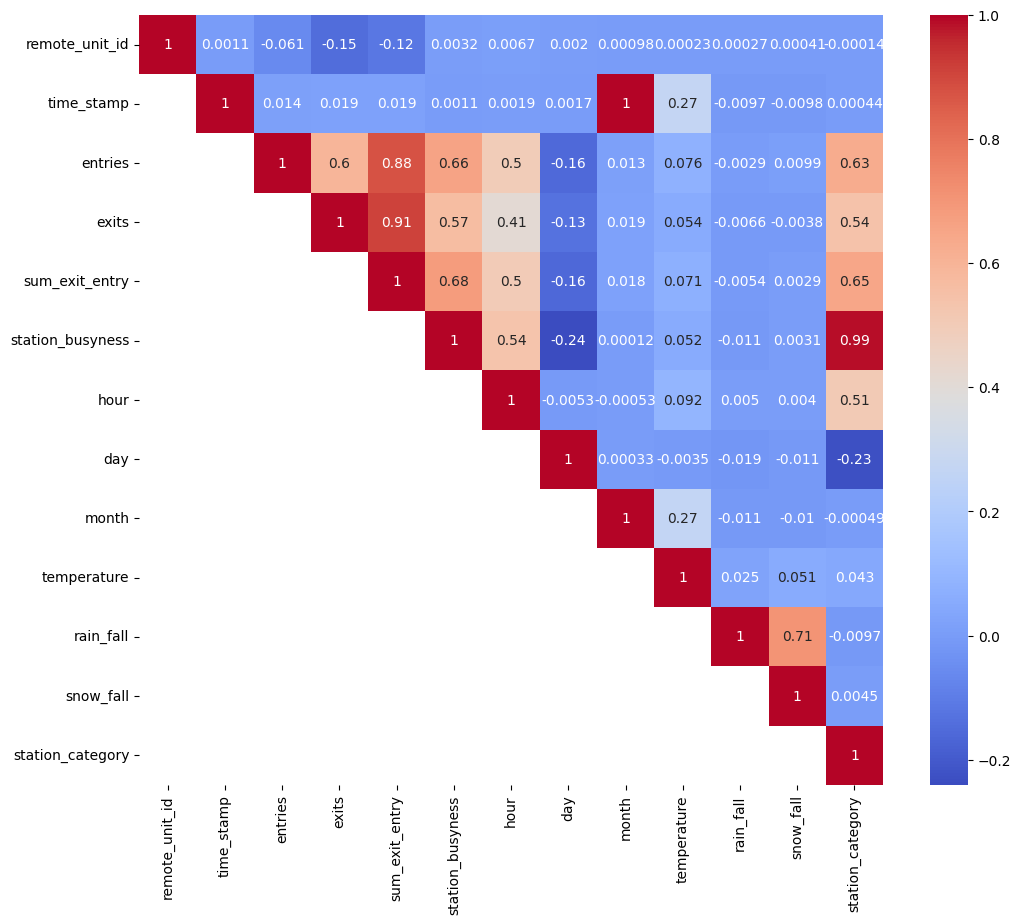

In [9]:
mat=df.corr()

# create a mask to drop the upper triangle
mask = np.triu(np.ones_like(mat, dtype=bool))

# apply the mask to the correlation matrix
mat = mat.where(mask)

fig, ax = plt.subplots(figsize=(12, 10))

sea.heatmap(mat, annot=True, cmap='coolwarm', ax=ax)

# show the plot
plt.show()

In [10]:
df.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits', 'sum_exit_entry',
       'station_busyness', 'hour', 'day', 'month', 'temperature', 'weather',
       'rain_fall', 'snow_fall', 'station_category'],
      dtype='object')

## One hot encoding for categorical features


In [11]:
one_hot = pd.get_dummies(df['weather'])
df = pd.concat([df, one_hot], axis = 1)

In [12]:
df.head()

,remote_unit_id,time_stamp,entries,exits,sum_exit_entry,station_busyness,hour,day,month,temperature,...,Clear,Clouds,Drizzle,Fog,Haze,Mist,Rain,Smoke,Snow,Thunderstorm
0,1,1546315200,102,104,206,0,4,2,1,5.89,...,0,0,0,0,0,0,1,0,0,0
1,1,1546329600,96,51,147,0,8,2,1,11.18,...,0,0,0,0,0,1,0,0,0,0
2,1,1546344000,260,476,736,0,12,2,1,13.55,...,0,0,0,0,0,0,1,0,0,0
3,1,1546358400,540,496,1036,0,16,2,1,11.68,...,0,0,0,0,0,0,1,0,0,0
4,1,1546372800,602,250,852,0,20,2,1,3.70,...,0,1,0,0,0,0,0,0,0,0


## Functions to train the models

- Choose either the busyness percentages or the actual footfall values
- For Busyness percentages use random forest classifer, for actual footfall values use random forest regressor


In [13]:
def divide_data_station_busy(station_number, dataframe):
    df_inner = dataframe[dataframe['remote_unit_id'] == station_number].copy()
    #print(df_main)
    y=df_inner['station_busyness'].values
    #drop these values for query search
    df_inner=df_inner.drop(columns=['sum_exit_entry','station_busyness','remote_unit_id','station_category'])
    X = df_inner.values
    
    # Split the data into train and test sets- alter this later to be tested on last 3 months? 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_inner, X_train, y_train, X_test, y_test

test_pred=[]
actual_pred=[]

test_mae_list = []
test_mape_list=[]
test_medae_list=[]
test_median_ape_list= []
test_rrmse_list=[]
test_score_list = []


def forest_training_model(train_x, train_y, test_x, test_y):
    #expirement with different parameters here
    forest = RandomForestRegressor(n_estimators=80, max_depth=10)
    forest = forest.fit(train_x, train_y)

    test_predictions = forest.predict(test_x)
    test_pred.append(test_predictions)
    actual_pred.append(test_y)

    test_mae = mean_absolute_error(test_y, test_predictions)
    test_mae_list.append(test_mae)

    test_mape = calculate_mape(test_y, test_predictions)
    test_mape_list.append(test_mape)

    test_medae = median_absolute_error(test_y, test_predictions)
    test_medae_list.append(test_medae)

    test_median_ape = median_absolute_percentage_error(test_y, test_predictions)
    test_median_ape_list.append(test_median_ape)

    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
    test_rrmse = test_rmse / np.mean(test_y)
    test_rrmse_list.append(test_rrmse)

    test_r2 = r2_score(test_y, test_predictions)
    test_score_list.append(test_r2)

    return forest


def calculate_mape(actual, predicted):
    # Calculate MAPE while handling zero values in actual
    mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1, actual)))
    return mape

def median_absolute_error(actual, predicted):
    absolute_errors = np.abs(actual - predicted)
    medae = np.median(absolute_errors)
    return medae

def median_absolute_percentage_error(actual,predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / np.where(actual == 0, 1, actual))
    median_ape = np.median(absolute_percentage_errors)
    return median_ape


In [14]:
# define function to perform cross-validation
def cross_val(model, X, y, cv=10):
    """Function to run the cross validation on the model"""
    results = pd.DataFrame(columns = ['accuracy','precision','recall', 'f1'])
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=0)
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

        model_instance = model().fit(X_train, y_train)
        
        test_predictions = model_instance.predict(X_test)

        mae = mean_absolute_error(y_test, test_predictions)

        mape = calculate_mape(y_test, test_predictions)

        medae = median_absolute_error(y_test, test_predictions)

        median_ape = median_absolute_percentage_error(y_test, test_predictions)

        test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
        rrmse = test_rmse / np.mean(y_test)

        r2 = r2_score(y_test, test_predictions)

        new_row = {"MAE": mae, "MAPE": mape, "MedAE": medae, "MedAPE": median_ape, "RRMSE": rrmse, "R2": r2}
        results = pd.concat([results, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    return results.describe(), test_predictions


# define function to perform cross-validation on different types of models
def cross_val_report(model,X,y,cv=10):
    """Function to perform cross validation on different types of models"""
    df,pred = cross_val(model, X,y, cv=cv)
    df_out = pd.concat([df], axis=1, keys=['random'])
    return df_out

## Description of the error metrics:

### Mean Absolute Error:
- This is the average of the absolute value of the errors between the predicted values and the actual values. This is the most intuitive of the metrics and is the easiest to understand. However, it is also the most sensitive to outliers.

### Mean Absolute Percentage Error:
- This is the average of the absolute percentage errors between the predicted values and the actual values. This metric is similar to the MAE, but it is a relative metric which is useful for comparing the performance of these models.

### Median Absolute Error:
- This is the median of the absolute value of the errors between the predicted values and the actual values. This metric is similar to the MAE, but it is more robust to outliers.
### Median Absolute Percentage Error:
- This is the median of the absolute percentage errors between the predicted values and the actual values. This metric is similar to the MAPE, but it is more robust to outliers.

### Relative Root Mean Squared Error:
- This is the RMSE divided by the standard deviation of the dependent variable. This metric is similar to the RMSE, but it is a relative metric which is useful for comparing the performance of these models.

### R2 Score:
- This is the proportion of the variance in the dependent variable that is predictable from the independent variables. This metric is useful for comparing the performance of these models.


## Function to save the models

In [15]:
def save_model_station_busy(model, station_number):
    filename = f'/home/cian/Documents/GitHub/NYSeeNow-ML/SubwayData/station_busy/s_busy_model_{station_number}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

### Clean the pickle dataframe 
- In order to reduce the size and time taken to run the models


In [16]:
df.drop(columns=['weather'], inplace=True)
df_pickle=df.copy()


In [17]:
df_pickle.columns

Index(['remote_unit_id', 'time_stamp', 'entries', 'exits', 'sum_exit_entry',
       'station_busyness', 'hour', 'day', 'month', 'temperature', 'rain_fall',
       'snow_fall', 'station_category', 'Clear', 'Clouds', 'Drizzle', 'Fog',
       'Haze', 'Mist', 'Rain', 'Smoke', 'Snow', 'Thunderstorm'],
      dtype='object')

### Drop features of least importance: thunderstorm, haze, fog, drizzle and smoke


In [18]:
#drop entries exits and timestamp from the pickle model, we wont know these to give to it, 
#and for each pickle one it cant have the other perctenage busyness

df_pickle.drop(columns=['time_stamp', 'entries', 'exits','Thunderstorm', 'Haze', 'Fog','Drizzle', 'Smoke'],axis=1,inplace=True)


In [19]:
df_pickle.columns

Index(['remote_unit_id', 'sum_exit_entry', 'station_busyness', 'hour', 'day',
       'month', 'temperature', 'rain_fall', 'snow_fall', 'station_category',
       'Clear', 'Clouds', 'Mist', 'Rain', 'Snow'],
      dtype='object')

In [20]:
df_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287399 entries, 0 to 287398
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   remote_unit_id    287399 non-null  int64  
 1   sum_exit_entry    287399 non-null  int64  
 2   station_busyness  287399 non-null  int64  
 3   hour              287399 non-null  int64  
 4   day               287399 non-null  int64  
 5   month             287399 non-null  int64  
 6   temperature       287399 non-null  float64
 7   rain_fall         287399 non-null  float64
 8   snow_fall         287399 non-null  float64
 9   station_category  287399 non-null  int64  
 10  Clear             287399 non-null  uint8  
 11  Clouds            287399 non-null  uint8  
 12  Mist              287399 non-null  uint8  
 13  Rain              287399 non-null  uint8  
 14  Snow              287399 non-null  uint8  
dtypes: float64(3), int64(7), uint8(5)
memory usage: 23.3 MB


In [21]:
#count the occurances of 1 in the following columns: Clear, Clouds, Drizzle, Fog etc
occurrences = df[['Clear', 'Clouds', 'Mist','Rain','Snow']].sum(axis=0)
occurrences


Clear     133598
Clouds     75600
Mist       17562
Rain       48114
Snow        3960
dtype: int64

## Execute the models

### Get station numbers

In [22]:
df_static = pd.read_csv('cleaned_station_data.csv')
check=df_static["remote_unit_id"]
order=check.tolist()
#now order the stations
order.sort()
#order
len(order)

143

## Code that runs and saves the models

- Keep the save commented to save writing the new models again

In [23]:
for station_number in df['remote_unit_id'].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data_station_busy(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    #save_model_station_busy(model, station_number)

    #get importances
    station_importance = pd.DataFrame({'feature': df_station.columns, 'importance':model.feature_importances_})
    station_importance.sort_values('importance', ascending=False)

    #have a mean importance value for each feature
    station_importance['importance'].mean()
    
#print average scores
print(f"Average Mean Absolute Error : {np.mean(test_mae_list):.6f}")
print(f"Average Mean Absolute Percentage Error : {np.mean(test_mape_list):.6f}")
print(f"Average Median Absolute Error : {np.mean(test_medae_list):.6f}")
print(f"Average Median Absolute Percentage Error : {np.mean(test_median_ape_list):.6f}")
print(f"Average Relative Root Mean Squared Error : {np.mean(test_rrmse_list):.6f}")
print(f"R squared test score : {np.mean(test_score_list):.6f}")


Average Mean Absolute Error : 8.119411
Average Mean Absolute Percentage Error : 2.544388
Average Median Absolute Error : 1.435137
Average Median Absolute Percentage Error : 0.090514
Average Relative Root Mean Squared Error : 0.753706
R squared test score : 0.769508


In [24]:
#compare the actual values with the predicted values:
df_compare = pd.DataFrame({'Actual': actual_pred, 'Predicted': test_pred})

In [25]:
df_compare.head(10)

,Actual,Predicted
0,"[0, 0, 0, 0, 0, 0, 60, 0, 0, 0, 0, 0, 0, 0, 0,...","[24.962297273982053, 0.0, 12.982007575757574, ..."
1,"[20, 0, 10, 10, 50, 0, 100, 0, 0, 60, 0, 10, 7...","[25.039466706443562, 1.2541666666666669, 5.944..."
2,"[0, 100, 90, 0, 100, 0, 0, 100, 0, 0, 0, 0, 10...","[0.5000104590443532, 78.30732778279082, 77.409..."
3,"[0, 10, 0, 0, 100, 0, 20, 100, 0, 0, 40, 0, 10...","[5.716096126729368, 35.77708333333334, 0.0, 0...."
4,"[0, 20, 100, 0, 0, 20, 0, 0, 50, 0, 100, 0, 0,...","[0.0, 23.94944283657519, 79.27678571428572, 0...."
5,"[0, 0, 20, 0, 20, 0, 50, 100, 0, 0, 0, 100, 0,...","[0.0, 0.0, 34.13530792363713, 41.8615128064947..."
6,"[0, 0, 0, 90, 0, 80, 0, 0, 100, 0, 0, 0, 0, 0,...","[21.61891391757859, 0.0, 0.0, 27.7556409565105..."
7,"[100, 100, 0, 100, 0, 100, 0, 0, 0, 0, 0, 100,...","[98.82261626795612, 88.89786567599069, 3.19753..."
8,"[0, 0, 0, 0, 0, 0, 0, 100, 0, 100, 0, 100, 0, ...","[6.088075660943277, 0.0, 0.0, 0.0, 8.646428571..."
9,"[100, 10, 0, 0, 100, 0, 100, 100, 70, 0, 100, ...","[96.67374199260512, 13.71640888727286, 0.125, ..."


In [26]:
y=df['station_busyness']
X=df_pickle.drop(columns=['station_busyness', 'sum_exit_entry', 'station_category'])

In [27]:
#do a linear regression cross val
#code taken from sample solution notebook
model=LinearRegression
report=cross_val_report(model, X, y, cv=10)
print(report)

          random                                                       
             MAE       MAPE      MedAE     MedAPE      RRMSE         R2
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000
mean   22.965148  10.998097  18.336787   5.593913   1.298286   0.349451
std     0.050661   0.051028   0.073505   0.056775   0.004557   0.001712
min    22.881641  10.928557  18.212443   5.512074   1.290757   0.346925
25%    22.941246  10.951560  18.305808   5.561755   1.295283   0.348087
50%    22.956567  11.023067  18.337321   5.580414   1.297391   0.349537
75%    22.993604  11.031436  18.391519   5.622565   1.302610   0.350749
max    23.063100  11.065113  18.436374   5.712771   1.304241   0.351880


In [28]:
model=RandomForestRegressor
report=cross_val_report(model, X, y, cv=3)
print(report)

         random                                                  
            MAE      MAPE     MedAE    MedAPE     RRMSE        R2
count  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000
mean   6.987309  1.942860  0.447222  0.033296  0.676129  0.823909
std    0.033611  0.010471  0.050231  0.002358  0.003125  0.000985
min    6.949066  1.932762  0.400000  0.031667  0.672599  0.822831
25%    6.974883  1.937455  0.420833  0.031944  0.674922  0.823483
50%    7.000701  1.942149  0.441667  0.032222  0.677244  0.824134
75%    7.006430  1.947908  0.470833  0.034111  0.677894  0.824448
max    7.012160  1.953668  0.500000  0.036000  0.678544  0.824762


In [29]:
#use xgboost
model=XGBRegressor
report=cross_val_report(model, X, y, cv=3)
print(report)


         random                                                  
            MAE      MAPE     MedAE    MedAPE     RRMSE        R2
count  3.000000  3.000000  3.000000  3.000000  3.000000  3.000000
mean   9.504055  3.397046  3.826088  0.891163  0.727033  0.796379
std    0.106500  0.030941  0.054254  0.011457  0.007768  0.004445
min    9.397522  3.370883  3.765760  0.877938  0.722173  0.791562
25%    9.450821  3.379970  3.803693  0.887716  0.722553  0.794408
50%    9.504120  3.389057  3.841627  0.897495  0.722933  0.797254
75%    9.557321  3.410127  3.856252  0.897776  0.729462  0.798787
max    9.610522  3.431197  3.870877  0.898056  0.735991  0.800320


In [30]:
model=GradientBoostingRegressor
report=cross_val_report(model, X, y, cv=3)
print(report)

          random                                                  
             MAE      MAPE     MedAE    MedAPE     RRMSE        R2
count   3.000000  3.000000  3.000000  3.000000  3.000000  3.000000
mean   13.160214  4.653728  7.215605  0.979702  0.958690  0.645979
std     0.100654  0.109276  0.271045  0.025243  0.007225  0.002867
min    13.060866  4.529618  6.911052  0.950601  0.950348  0.643166
25%    13.109258  4.612842  7.108237  0.971705  0.956545  0.644520
50%    13.157649  4.696067  7.305422  0.992808  0.962742  0.645875
75%    13.209887  4.715783  7.367882  0.994252  0.962861  0.647386
max    13.262125  4.735500  7.430341  0.995696  0.962980  0.648897


### Reults of Cross-Validation:
- Random forest regressor performs better than GradientBoostingRegressor, XGBoost and Linear Regression
- Use random forest

## Lets analyse this further- use data hmw2

### Feature Importance for Random Forest for station busyness

In [35]:
#change importance column to % and no decimal places
station_importance['importance %'] = station_importance['importance'].apply(lambda x: round(x*100, 2))
station_importance.sort_values('importance', ascending=False)

,feature,importance,importance %
0,hour,0.469056,46.91
1,day,0.313446,31.34
3,temperature,0.106310,10.63
2,month,0.057482,5.75
5,snow_fall,0.016960,1.70
4,rain_fall,0.011438,1.14
7,Clouds,0.011081,1.11
6,Clear,0.006425,0.64
8,Mist,0.004091,0.41
9,Rain,0.001925,0.19


### Description of the models:
- I have made a prediciton model that only need the remote unit id, which can be easily mapped from the lookup table
- Choose tation busyness prediction by selecting the correct folder
- Select the Remote Unit id using the cleaned_station_data.csv file
- The model also requires the following to get the prediciton:
- hour as an int with 0 being midnight, 1 being 1AM etc
- day as an int with 1 being Monday etc
- month as int with 1 being January etc
- temperature as float in Celsius
- rain_fall as float in mm per hour
- snow_fall as float in mm per hour
- Clear as a int, 1 or  0
- Clouds as a int, 1 or  0, Mist, Rain and Snow